## Загрузка данных

Импортируем необходимые библиотеки.

In [58]:
import pandas as pd
import numpy as np
import json
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

Загрузим файл, содержащий разметку изображений.

In [62]:
with open('data.json') as json_file:
    data = json.load(json_file)

Данный объект представляет из себя словарь списков, в которых еще находятся словари. Довольно сложная структура. Посмотрим на ключи словаря.

In [7]:
data.keys()

dict_keys(['initial_bundle', 'test_bundle'])

Словарь содержит 2 списка. Делаем вывод, что в первом данные для обучения, во втором для тестирования.

Сохраним оба списка в отдельные переменные.

In [8]:
train = data.get('initial_bundle')
test = data.get('test_bundle')

Для понимания, что находится в списках, посмотрим на первые два элемента.

In [9]:
train[0:2]

[{'id': 2703,
  'type': {'id': 20, 'name': 'Showcase & Finals'},
  'category': {'id': 133,
   'name': 'Installations',
   'type': {'id': 20, 'name': 'Showcase & Finals'}},
  'subcategory': None,
  'tags': ['2022', 'doha', 'fan', 'fifa', 'fooball', 'qatar', 'zone'],
  'file': 'data/bf0d8c12-950b-4760-8deb-3a562cd7fe5b.jpg'},
 {'id': 3337,
  'type': {'id': 2, 'name': 'Textures'},
  'category': {'id': 175,
   'name': 'cyber',
   'type': {'id': 2, 'name': 'Textures'}},
  'subcategory': None,
  'tags': ['cyber', 'cyberpunk', 'neon', 'pixel', 'sign'],
  'file': 'data/021d56b2-305b-443a-b45b-17ca7eafc3e9.jpg'}]

Элементами списка являются словари. Для нашей задачи нам нужны лишь название категории и имя файла. Мы можем пройтись по всем элементам списка и собрать необходимую нам информацию.

Создадим папки для обучающей и тестовой выборок. В папке обучающей выборки создадим папки для машин, растений и остальных категорий. В эти папки будем копировать соответствующие изображения.

In [10]:
os.mkdir('train')
os.mkdir('train/vehicles')
os.mkdir('train/plants')
os.mkdir('train/other')
os.mkdir('test')

Теперь пройдемся по списку с данными обучающей выборки и получим необходимые данные о каждом изображении - категорию и путь к файлу. Скопируем все изображения в соответствующие им папки.

In [11]:
train_data = []
for i in range(len(train)):
    old_path = train[i].get('file')
    if train[i].get('category') == None:
        category_name = 'unknown'
    else:
        category_name = train[i].get('category').get('name')
    if category_name == 'Vehicles':
        new_path = 'train/vehicles/' + old_path[5:]
    elif category_name == 'Plants':
        new_path = 'train/plants/' + old_path[5:]
    else:
        new_path = 'train/other/' + old_path[5:]
    shutil.copyfile(old_path, new_path)
    train_data.append([old_path, new_path, category_name])
df_train = pd.DataFrame(train_data, columns=['old_path', 'new_path', 'category_name'])

In [12]:
df_train.head()

,old_path,new_path,category_name
0,data/bf0d8c12-950b-4760-8deb-3a562cd7fe5b.jpg,train/other/bf0d8c12-950b-4760-8deb-3a562cd7fe...,Installations
1,data/021d56b2-305b-443a-b45b-17ca7eafc3e9.jpg,train/other/021d56b2-305b-443a-b45b-17ca7eafc3...,cyber
2,data/9c3909df-21d4-4e84-805d-ade67f2df990.png,train/other/9c3909df-21d4-4e84-805d-ade67f2df9...,Buildings
3,data/cd06f94b-179e-4634-87eb-d1b77cd06bfe.jpg,train/other/cd06f94b-179e-4634-87eb-d1b77cd06b...,Light Textures
4,data/e0734308-0fe8-4145-a968-17039966b48c.jpg,train/other/e0734308-0fe8-4145-a968-17039966b4...,Light Textures


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   old_path       1558 non-null   object
 1   new_path       1558 non-null   object
 2   category_name  1558 non-null   object
dtypes: object(3)
memory usage: 36.6+ KB


In [14]:
df_train['category_name'].value_counts()

Light Textures    210
Vehicles          175
Plants            150
Explosions         74
Other              72
                 ... 
Impulse             1
Animals             1
Clouds              1
LED Facades         1
Wipe Mark           1
Name: category_name, Length: 73, dtype: int64

В обучающей выборке имеем 175 изображений машин и 150 изображений растений. 

Посмотрим, нет ли в выборке изображений, который имеют категорию, близкую к машинам (например Cars, Autos или что-то похожее) или растениям.

In [15]:
df_train['category_name'].unique()

array(['Installations', 'cyber', 'Buildings', 'Light Textures',
       'Vehicles', 'Architecture', 'Indoor', 'Space', 'Kitbash', 'Plants',
       'Human', 'Other', 'Splashes', 'Dust', 'Outdoor', 'Sparks',
       'Simulation', 'Particles', 'Creatures', 'Studios', 'Debris',
       'People', 'Noises', 'Explosions', 'Abstract', 'Stages',
       'Industrial', 'Electronics', 'Toys and games', 'Shapes', 'Science',
       'LED Facades', 'Dome', 'Background', 'Interior', 'Animals',
       'Lines', 'SciFi', 'Typography', 'Smoke', 'Sky', 'Objects',
       'Windows', 'Light', 'Gradients', 'Stock', 'Walls', 'Exterior',
       'Mapping', 'Digital', 'Stone', 'Glass', 'Real People', 'Clouds',
       'Presentations', 'Signs & Symbols', 'Grids & Dots', 'Nature',
       'Impulse', 'Performances', 'Flame', 'Stones', 'Pointers', 'Flares',
       'Data Flows', 'Map', 'Grunge', 'Special', 'Grids', 'Metals',
       'Dirt', 'Identity', 'Wipe Mark'], dtype=object)

Таких категорий не обнаружено.

Проделаем ту же операцию для тестовой выборки.

In [16]:
test_data = []
for i in range(len(test)):
    old_path = test[i].get('file')
    if test[i].get('category') == None:
        category_name = 'unknown'
    else:
        category_name = test[i].get('category').get('name')
    new_path = 'test/' + old_path[5:]
    shutil.copyfile(old_path, new_path)
    file_name = old_path[5:]
    test_data.append([file_name, new_path, category_name])
    
df_test = pd.DataFrame(test_data, columns=['file_name', 'new_path', 'category_name'])

In [17]:
df_test.head()

,file_name,new_path,category_name
0,7e5ba16b-6223-41f3-8f64-07ea079ece48.png,test/7e5ba16b-6223-41f3-8f64-07ea079ece48.png,Plants
1,ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,test/ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,Buildings
2,386d835c-bc56-4d6d-bb45-98741b3a68a4.png,test/386d835c-bc56-4d6d-bb45-98741b3a68a4.png,Typography
3,25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,test/25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,Studios
4,c83b3205-ec7c-4847-ba23-92348c220263.jpg,test/c83b3205-ec7c-4847-ba23-92348c220263.jpg,Explosions


По большому счету, нам необязательно знать категории кроме растений и машин. Добавим столбец, где заменим неинтересующие нас категории.

In [18]:
df_test['category_group'] = df_test['category_name'].apply(lambda x: x if x == 'Plants' or x == 'Vehicles' else 'Other')

In [19]:
df_test.head(10)

,file_name,new_path,category_name,category_group
0,7e5ba16b-6223-41f3-8f64-07ea079ece48.png,test/7e5ba16b-6223-41f3-8f64-07ea079ece48.png,Plants,Plants
1,ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,test/ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,Buildings,Other
2,386d835c-bc56-4d6d-bb45-98741b3a68a4.png,test/386d835c-bc56-4d6d-bb45-98741b3a68a4.png,Typography,Other
3,25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,test/25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,Studios,Other
4,c83b3205-ec7c-4847-ba23-92348c220263.jpg,test/c83b3205-ec7c-4847-ba23-92348c220263.jpg,Explosions,Other
5,d062fd1b-b3f5-4bf1-ad8f-71f327c4d2f9.png,test/d062fd1b-b3f5-4bf1-ad8f-71f327c4d2f9.png,Stages,Other
6,838cffc0-ee3b-4025-a7aa-9244a32cfa0c.jpg,test/838cffc0-ee3b-4025-a7aa-9244a32cfa0c.jpg,Sparks,Other
7,4af0e5ff-33d9-4b0c-9dc6-b7a544221c50.png,test/4af0e5ff-33d9-4b0c-9dc6-b7a544221c50.png,Industrial,Other
8,2873600a-fa17-4625-94c9-0a728b563dab.png,test/2873600a-fa17-4625-94c9-0a728b563dab.png,Vehicles,Vehicles
9,0a8e8f55-a8b9-41d9-b89b-3101b88fa7d3.png,test/0a8e8f55-a8b9-41d9-b89b-3101b88fa7d3.png,Science,Other


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_name       1545 non-null   object
 1   new_path        1545 non-null   object
 2   category_name   1545 non-null   object
 3   category_group  1545 non-null   object
dtypes: object(4)
memory usage: 48.4+ KB


In [21]:
df_test['category_name'].value_counts()

Light Textures    217
Vehicles          182
Plants            115
Explosions         68
Studios            64
                 ... 
Grids               1
Art                 1
LED Facades         1
Music               1
Identity            1
Name: category_name, Length: 72, dtype: int64

В тестовой выборке 1545 изображений, из которых 182 машины и 115 растений.

## Обработка данных

Создадим обучающую и тестовую выборки.

In [22]:
image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    validation_split=0.25,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    validation_split=0.25,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1558 files belonging to 3 classes.
Using 1169 files for training.
Found 1558 files belonging to 3 classes.
Using 389 files for validation.


Имеем 3 класса - машины, растения и всё остальное.

Посмотреть на 16 изображений из обучающей выборки.

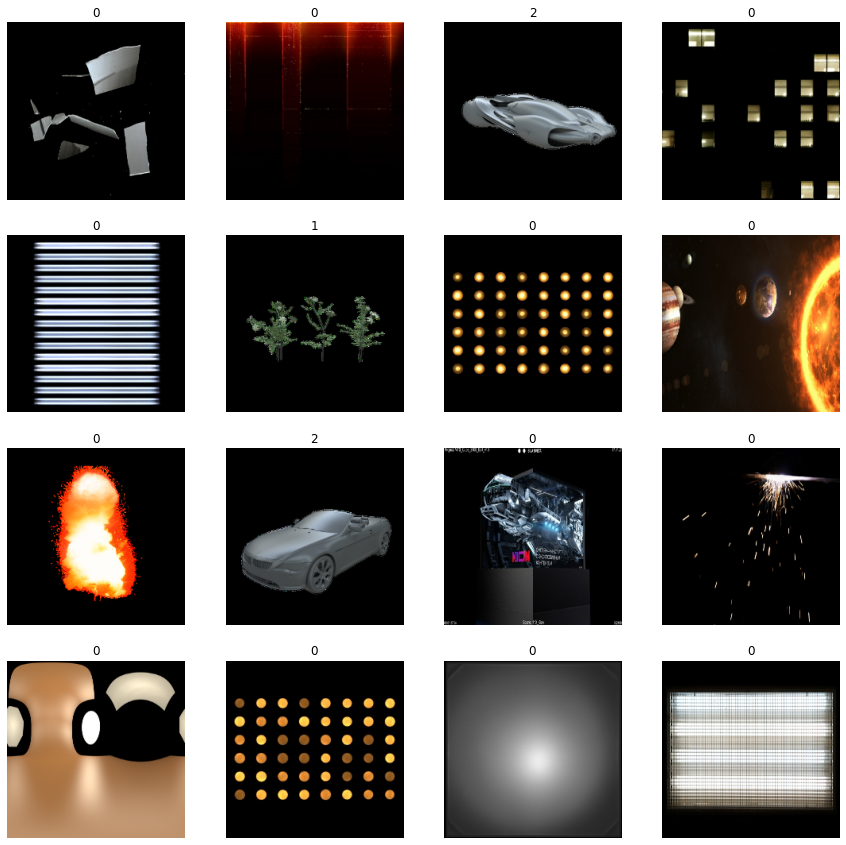

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

Класс 0 - другие изображения, класс 1 - растения, класс 2 - машины.

Используем слои предварительной обработки для увеличения данных.

In [27]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.75, 0.75)]
)

Применим их несколько раз к одному и тому же изображению.

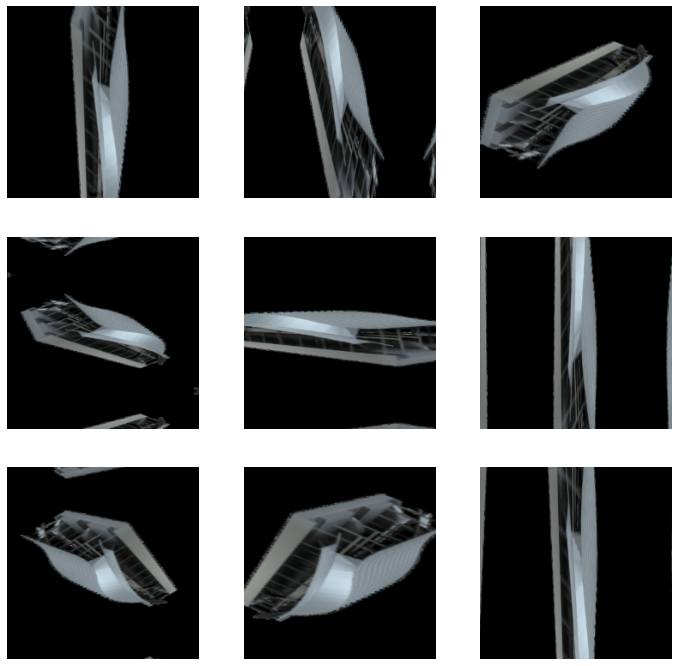

In [28]:
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Создадим слой для для изменения масштаба.

In [29]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)])

Применяем аугментацию к обучающей выборке.

In [30]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Применяем изменение масштаба к обучающей и валидационной выборкам.

In [31]:
final_train_ds = augmented_train_ds.map(lambda x, y: (rescale(x, training=True), y))
final_val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [32]:
final_train_ds = final_train_ds.prefetch(buffer_size=32)
final_val_ds = final_val_ds.prefetch(buffer_size=32)

## Создание и обучение модели

Создадим сверточную нейронную сеть с тремя слоями свертки и двумя полносвязными слоями с 512 нейронами. На всех слоях в качестве функции активации будем использовать ReLU.

In [33]:
cnn = tf.keras.models.Sequential()

cnn.add(Conv2D(filters=48, kernel_size=11, padding='same', input_shape=[224, 224, 3]))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2))
        
cnn.add(Conv2D(filters=128, kernel_size=5, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2))
        
cnn.add(Conv2D(filters=256, kernel_size=3, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2))
        
cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))  


cnn.add(Dense(3))
cnn.add(BatchNormalization())
cnn.add(Activation('softmax'))

In [34]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 48)      17472     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 48)     192       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 48)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 48)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     153728    
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 128)   

Скомпилируем и обучим модель. Количество эпох - 50. Если производительность модели на валидационной выборке не улучшается в течение 5 эпох, то обучение останавливаем.

In [35]:
epochs = 100

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1),
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5', save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True)
]
cnn.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
cnn.fit(
    final_train_ds, epochs=epochs, callbacks=callbacks, validation_data=final_val_ds, use_multiprocessing=True
)

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 1.1380 - accuracy: 0.4739
Epoch 1: val_loss improved from inf to 1.17421, saving model to save_at_1.h5
74/74 [==============================] - 144s 2s/step - loss: 1.1380 - accuracy: 0.4739 - val_loss: 1.1742 - val_accuracy: 0.3445
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.5808
Epoch 2: val_loss did not improve from 1.17421
74/74 [==============================] - 142s 2s/step - loss: 0.9815 - accuracy: 0.5808 - val_loss: 1.3735 - val_accuracy: 0.1877
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.6741
Epoch 3: val_loss improved from 1.17421 to 1.07807, saving model to save_at_3.h5
74/74 [==============================] - 143s 2s/step - loss: 0.8996 - accuracy: 0.6741 - val_loss: 1.0781 - val_accuracy: 0.5347
Epoch 4/100
74/74 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.7126
Epoch 4: val_loss did not

## Предсказания

Создадим функцию для предсказаний. 

In [36]:
def make_prediction(df):    
    '''
    На вход функция получает датафрейм, затем через значение в столбце *new_path* получает доступ к изображению. 
    Затем обученная модель предсказывает вероятность изображения принадлежать к тому или иному классу. 
    На выход подается вероятность принадлежать классу "Растения", вероятность принадлежать классу "Машины" 
    и категорию, чья вероятность выше остальных.
    '''
    path = df['new_path']
    img = keras.preprocessing.image.load_img(
        path, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = rescale(img_array)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    dict_category = {
        0 : 'Other',
        1 : 'Plants',
        2 : 'Vehicles'
    }

    predictions = cnn.predict(img_array)
    plants_prob = predictions[0][1]
    vehicles_prob = predictions[0][2]
    predicted_category = dict_category.get(np.argmax(predictions[0]))

    return plants_prob, vehicles_prob, predicted_category

Сделаем предсказания для всех файлов тестовой выборки. Вероятность оказаться растением, машиной, а также предсказанную категорию запишем в отдельные столбцы.

In [37]:
df_test[['plants_prob','vehicles_prob', 'predicted_category']] = df_test.apply(make_prediction, axis=1, result_type ='expand')

In [38]:
df_test.head()

,file_name,new_path,category_name,category_group,plants_prob,vehicles_prob,predicted_category
0,7e5ba16b-6223-41f3-8f64-07ea079ece48.png,test/7e5ba16b-6223-41f3-8f64-07ea079ece48.png,Plants,Plants,0.940024,0.059850,Plants
1,ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,test/ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,Buildings,Other,0.416819,0.323049,Plants
2,386d835c-bc56-4d6d-bb45-98741b3a68a4.png,test/386d835c-bc56-4d6d-bb45-98741b3a68a4.png,Typography,Other,0.075870,0.105383,Other
3,25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,test/25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,Studios,Other,0.188378,0.095448,Other
4,c83b3205-ec7c-4847-ba23-92348c220263.jpg,test/c83b3205-ec7c-4847-ba23-92348c220263.jpg,Explosions,Other,0.176402,0.156374,Other


In [39]:
df_test[['plants_prob','vehicles_prob']] = df_test[['plants_prob','vehicles_prob']].round(4)

In [40]:
df_test.head()

,file_name,new_path,category_name,category_group,plants_prob,vehicles_prob,predicted_category
0,7e5ba16b-6223-41f3-8f64-07ea079ece48.png,test/7e5ba16b-6223-41f3-8f64-07ea079ece48.png,Plants,Plants,0.9400,0.0599,Plants
1,ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,test/ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,Buildings,Other,0.4168,0.3230,Plants
2,386d835c-bc56-4d6d-bb45-98741b3a68a4.png,test/386d835c-bc56-4d6d-bb45-98741b3a68a4.png,Typography,Other,0.0759,0.1054,Other
3,25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,test/25db6f12-b897-41e8-a6ed-e2a3c83f6668.png,Studios,Other,0.1884,0.0954,Other
4,c83b3205-ec7c-4847-ba23-92348c220263.jpg,test/c83b3205-ec7c-4847-ba23-92348c220263.jpg,Explosions,Other,0.1764,0.1564,Other


Посчитаем долю корректно распознанных объектов.

In [41]:
len(df_test[df_test['category_group'] == df_test['predicted_category']]) / len(df_test)

0.8453074433656957

Посмотрим, сколько изображений разных категорий в тестовой выборке, а также сравним с предсказаниями.

In [42]:
pd.concat([df_test['category_group'].value_counts().to_frame(), 
           df_test['predicted_category'].value_counts().to_frame()], axis=1)

,category_group,predicted_category
Other,1248,1072
Vehicles,182,181
Plants,115,292


Можем сделать вывод, что модель видит растения там, где их нет.

По условию задания нужно вывести на экран список файлов в каждой категории с указанием вероятности совпадения.

Сначала выведим файлы, распознанные как "Машины", и их вероятоность совпадения.

In [43]:
with pd.option_context('display.max_rows', None):  
    display(df_test.query('predicted_category == "Vehicles"')[['file_name', 'vehicles_prob']])

,file_name,vehicles_prob
8,2873600a-fa17-4625-94c9-0a728b563dab.png,0.7217
10,dbdd0799-f355-4239-ba16-7ce31bce9c10.png,0.6054
14,e3ab835d-97be-4253-ad5b-6aded3f57886.png,0.4564
20,a3b03e73-3c82-4d12-8041-c79fdeb135a7.png,0.7326
21,b9ab1dce-0899-418a-b57b-cfea48ab4f04.png,0.6630
32,0774d809-adf2-4b33-bf8f-cfc905865a04.png,0.7192
46,d276be2b-e764-40ae-b873-1ff05595438e.png,0.7265
49,7559e15e-4cab-4b46-bafd-06916d121004.png,0.7455
73,95c581a4-3065-4698-885b-ffc18704463e.png,0.7452
85,95009b84-d893-4844-af9f-6e30d932af61.png,0.5746


Теперь тоже самое для растений.

In [44]:
with pd.option_context('display.max_rows', None):  
    display(df_test.query('predicted_category == "Plants"')[['file_name', 'plants_prob']])

,file_name,plants_prob
0,7e5ba16b-6223-41f3-8f64-07ea079ece48.png,0.9400
1,ef6e4cfe-c96a-4cd1-b30c-0e966dc46c83.png,0.4168
7,4af0e5ff-33d9-4b0c-9dc6-b7a544221c50.png,0.3925
9,0a8e8f55-a8b9-41d9-b89b-3101b88fa7d3.png,0.5709
13,455ae0e8-7aac-495c-947e-e85a5f404e3d.jpg,0.4323
22,6be2a5ea-72f9-4e30-9d97-0a0511ead45d.png,0.9391
24,2a2b3634-a700-45c2-9af9-ea8ffc080466.png,0.5049
27,e1598c6b-61ac-4575-87e0-9e6c643bb9fa.png,0.8717
29,4f368b63-24c7-424d-83da-6c285cd3e64b.png,0.5619
39,a3b3a6f7-9267-4011-85c2-a8b366a5e9d9.png,0.8949
